# Resume Parsing

## 1. Load data

In [1]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("data/resume.csv")

In [2]:
df_resume.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [3]:
df_resume.shape

(2484, 4)

In [4]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]
df_resume.shape

(1000, 4)

## 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [5]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = 'data/skills.jsonl'

In [6]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [7]:
doc = nlp("Chaky loves ajax.")
doc.ents

(Chaky, ajax)

## 3. Let's try to extract skills from this resume.csv

In [8]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
1770,19397727,ENGINEERING TECHNICIAN III Summ...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING
1167,20314980,CONSULTANT Summary I am an e...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT
946,20969119,CHIEF ADMINISTRATIVE OFFICER ...,"<div class=""fontsize fontface vmargins hmargin...",AGRICULTURE
2476,29534737,PRODUCTION SUPERVISOR / VALUE STREAM ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION
1853,25067742,ACCOUNTANT Summary If you ne...,"<div class=""fontsize fontface vmargins hmargin...",ACCOUNTANT


In [9]:
#clean our data
from spacy.lang.en.stop_words import STOP_WORDS

def preprocessing(sentence):
    stopwords    = list(STOP_WORDS)
    doc          = nlp(sentence)
    clean_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SYM' and \
            token.pos_ != 'SPACE':
                clean_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(clean_tokens)

In [10]:
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         ENGINEERING MANAGER       Summary    Versatile bilingual Electronics and Instrumentation\nEngineer with multi industry experience of + 9 years demonstrated ability to lead\nan engineering team, and handle multiple projects from conceptualization through fabrication with high accuracy and in a'

In [11]:
preprocessing(random_resume[:300])

'engineering manager summary versatile bilingual electronics instrumentation engineer multi industry experience + 9 year demonstrate ability lead engineering team handle multiple project conceptualization fabrication high accuracy'

In [12]:
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [13]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
1770,19397727,ENGINEERING TECHNICIAN III Summ...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING,engineer technician iii summary engineering te...
1167,20314980,CONSULTANT Summary I am an e...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT,consultant summary i experienced program manag...
946,20969119,CHIEF ADMINISTRATIVE OFFICER ...,"<div class=""fontsize fontface vmargins hmargin...",AGRICULTURE,chief administrative officer executive profile...
2476,29534737,PRODUCTION SUPERVISOR / VALUE STREAM ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION,production supervisor value stream leader summ...
1853,25067742,ACCOUNTANT Summary If you ne...,"<div class=""fontsize fontface vmargins hmargin...",ACCOUNTANT,accountant summary if need deliver sharp resul...


## 4. Let's really extract skills!!

In [14]:
def get_skills(text):
    
    doc = nlp(text)
    
    skills = []
    
    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
            
    return unique_skills(skills)

def unique_skills(x):
    return list(set(x))

In [15]:
nlp.get_pipe("ner").labels

('CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART')

In [16]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [17]:
df_resume.Skills.iloc[0]

['testing',
 'engineering',
 'design',
 'data acquisition',
 'mobile',
 'component',
 'diagram',
 'software',
 'database',
 'aeronautics',
 'functional testing']

## 5. Visualization

Which skills is most important in information management?

In [18]:
# set(df_resume.Category)

In [19]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(51, 6)

In [20]:
all_skills = np.concatenate(df_resume_it.Skills.values)

In [21]:
from collections import Counter, OrderedDict

counting = Counter(all_skills)
counting = OrderedDict(counting.most_common(10))

In [22]:
counting

OrderedDict([('support', 47),
             ('software', 42),
             ('design', 37),
             ('business', 36),
             ('security', 32),
             ('windows', 31),
             ('server', 30),
             ('project management', 27),
             ('database', 23),
             ('documentation', 22)])

<BarContainer object of 10 artists>

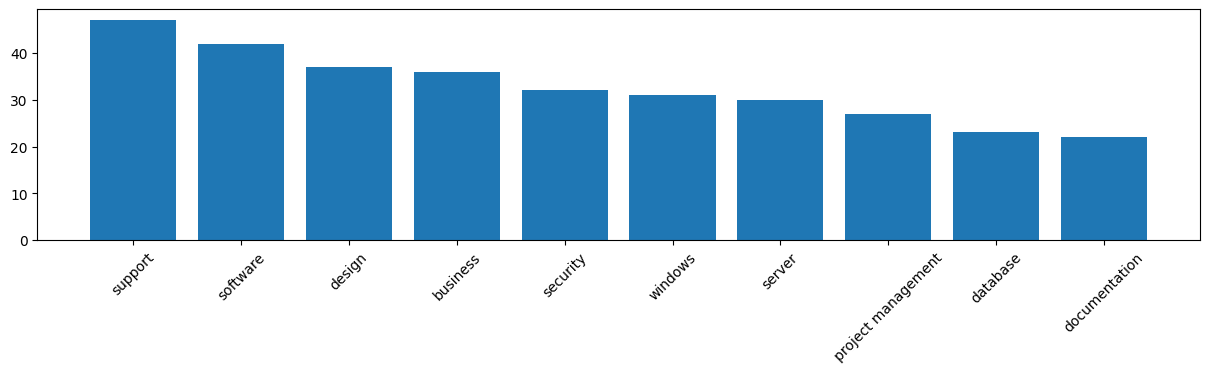

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation=45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [24]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[32]

In [25]:
doc = nlp(text)

In [26]:
# colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
# options = {"colors": colors}

# displacy.render(doc, style='ent', options=options)

## 7. Let's load the PDF - add some realism

In [27]:
from PyPDF2 import PdfReader

reader = PdfReader("data/chaklam_resume.pdf")
page = reader.pages[0]
text = page.extract_text()

In [28]:
text = preprocessing(text)

In [29]:
doc = nlp(text)

In [30]:
doc

chaklam silpasuwanchai email chaklam@ait.asia http://chaklam.com mobile +66 - 63 310 - 9191 http://github.com/chaklam-silpasuwanchai skill •language python java •tool frameworks pytorch springboot •theory machine deep learning natural language processing software engineering hypothesis testing data structures algorithms selected projects •bci speller develop real time speller eeg lock patient •large language models develop conversational ai legal question answering university chatbot summarization etc . large language model •non invasive blood glucose measuring use raman spectroscopy utilize raman spectroscopy non - invasively measure blood glucose fingernail •medical imaging utilize deep learning language model medical image analysis explanation working experience •asian institute technology pathumthani thailand assistant professor school engineering technology january 2019 present •stamford international university bangkok thailand faculty it program faculty business technology march

In [31]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style='ent', options=options)

## 8. Additional Features

### Obtain entities table

Let's obtain an entities table to find all entities for each entity type that exist in the resume.

In [44]:
# modified from get_skill function
def get_entities(text):
    
    doc = nlp(text)
    
    entities = {}
    
    for ent in doc.ents:
        if ent.label_ in entities:
            entities[ent.label_].append(ent.text)
        else:
            entities[ent.label_] = [ent.text]

    for ent_type in entities.keys():
        entities[ent_type] = ', '.join(unique_list(entities[ent_type]))
            
    return pd.DataFrame.from_records([entities], index=['Resume'])

def unique_list(x):
    return list(set(x))

In [80]:
# modified from get_skill function
def get_entities(resumes):

    output = {
        'PERSON': [],
        'SKILL': [],
        'PRODUCT': [],
        'ORG': []
    }
    
    for resume in resumes:
        doc = nlp(resume)
        
        entities = {}
        
        for ent in doc.ents:
            if ent.label_ in output:
                if ent.label_ in entities:
                    entities[ent.label_].append(ent.text)
                else:
                    entities[ent.label_] = [ent.text]

        for ent_type in output.keys():
            try:
                output[ent_type].append(', '.join(unique_list(entities[ent_type])))
            except:
                output[ent_type].append('-')
            
    return output

In [82]:
resume_ents = get_entities([text, text])
resume_ents

{'PERSON': ['chaklam silpasuwanchai email, silpasuwanchai c. cheng, roman w. silpasuwanchai c., pananookooln c. akaranee j. silpasuwanchai c. compare, •large, silpasuwanchai c. ren x. sex, sarcar s. jokinen j. oulasvirta a. wang z. silpasuwanchai c. ren',
  'chaklam silpasuwanchai email, silpasuwanchai c. cheng, roman w. silpasuwanchai c., pananookooln c. akaranee j. silpasuwanchai c. compare, •large, silpasuwanchai c. ren x. sex, sarcar s. jokinen j. oulasvirta a. wang z. silpasuwanchai c. ren'],
 'SKILL': ['algorithms, design, localization, business, computer science, language model, python, java, interaction, deep learning, ai, framework, question answering, pytorch, testing, mobile, engineering, natural language processing, software engineering, data structures',
  'algorithms, design, localization, business, computer science, language model, python, java, interaction, deep learning, ai, framework, question answering, pytorch, testing, mobile, engineering, natural language processi

### Find all people names

Finding person entities using the entity rule are not perfect so let's use spaCy's Matcher module to help identify persons in the resume better

In [73]:
from spacy.matcher import Matcher

In [74]:
matcher = Matcher(nlp.vocab)
pattern = [
    {"POS": "PROPN",  # person's name should be a proper noun
     "OP": "{2}",  # person's name usually consists of 2 parts; first name and last name (in some scenario, 3 if a person has middle name)
     "ENT_TYPE": "PERSON"  # person's name is of 'PERSON' entity type
    },
]
matcher.add("PERSON NAME", [pattern], greedy="LONGEST")

In [75]:
matches = matcher(doc)
matches.sort(key = lambda x: x[1])

In [76]:
person_names = []

for match in matches:
    person_names.append((str(doc[match[1]:match[2]]),
                         nlp.vocab.strings[match[0]]))

person_names = list(set(person_names))
person_names

[('pananookooln c.', 'PERSON NAME'),
 ('chaklam silpasuwanchai', 'PERSON NAME'),
 ('roman w.', 'PERSON NAME'),
 ('sarcar s.', 'PERSON NAME'),
 ('ren x.', 'PERSON NAME'),
 ('silpasuwanchai c.', 'PERSON NAME'),
 ('jokinen j.', 'PERSON NAME'),
 ('wang z.', 'PERSON NAME'),
 ('oulasvirta a.', 'PERSON NAME'),
 ('akaranee j.', 'PERSON NAME')]

In [77]:
matcher.add("EMAIL", [[{"LIKE_EMAIL": True}]], greedy="LONGEST")
matcher.add("URL", [[{"LIKE_URL": True}]], greedy="LONGEST")

In [78]:
matches = matcher(doc)
matches.sort(key = lambda x: x[1])

In [79]:
entities = []

for match in matches:
    entities.append((str(doc[match[1]:match[2]]),
                         nlp.vocab.strings[match[0]]))

entities = list(set(entities))
entities

[('http://chaklam.com', 'URL'),
 ('pananookooln c.', 'PERSON NAME'),
 ('chaklam silpasuwanchai', 'PERSON NAME'),
 ('roman w.', 'PERSON NAME'),
 ('http://github.com/chaklam-silpasuwanchai', 'URL'),
 ('sarcar s.', 'PERSON NAME'),
 ('chaklam@ait.asia', 'EMAIL'),
 ('silpasuwanchai c.', 'PERSON NAME'),
 ('ren x.', 'PERSON NAME'),
 ('jokinen j.', 'PERSON NAME'),
 ('https://doi.org/10.1145/3359593', 'URL'),
 ('oulasvirta a.', 'PERSON NAME'),
 ('wang z.', 'PERSON NAME'),
 ('akaranee j.', 'PERSON NAME')]